<a href="https://colab.research.google.com/github/shree180103/dcgan_mnist/blob/main/dcgan_with_fid_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

In [2]:
torch.cuda.is_available()

True

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Discriminator(nn.Module):
  def __init__(self,input_shape:int):
    super().__init__()
    self.patch_gan=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=1,bias=False,padding_mode="reflect"),

    )

  def forward(self,x):
      return self.patch_gan(x)


In [5]:
# def test():
#     x=torch.rand(size=(1,3,256,256)).to('cuda')
#     model1=Discriminator(input_shape=3).to('cuda')

#     preds=model1(x)
#     print(preds.shape)

# test()

In [6]:
class Generator(nn.Module):
  def __init__(self,img_channels:int):
    super().__init__()
    self.conv_block_down=nn.Sequential(
        nn.Conv2d(in_channels=img_channels,out_channels=64,kernel_size=7,stride=1,padding=3,bias=False,padding_mode="reflect"),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True)
    )
    self.conv_block_up=nn.Sequential(
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
        nn.InstanceNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
        nn.InstanceNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(in_channels=64,out_channels=3,kernel_size=7,stride=1,padding=3,bias=False,padding_mode="reflect")
        
    )

    self.conv_res_block=nn.Sequential(
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False,padding_mode="reflect"),
        nn.InstanceNorm2d(256),
    )
    self.relu=nn.ReLU()

  def forward(self,x):
      x=self.conv_block_down(x)
      for i in range(9):
          res=x
          output=self.conv_res_block(x)
          x=self.relu(output+res)

      return torch.tanh(self.conv_block_up(x))
      
      
    
          


In [7]:
# def test():
#     x=torch.rand(size=(1,3,256,256)).to('cuda')
#     model1=Generator(img_channels=3).to('cuda')
#     preds=model1(x)
#     print(preds.shape)


# test()

In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
n_c=3

gen_G=Generator(img_channels=n_c).to(device)
gen_G.apply(weights_init)

gen_F=Generator(img_channels=n_c).to(device)
gen_F.apply(weights_init)

disc_x=Discriminator(input_shape=n_c).to(device)
disc_x.apply(weights_init)

disc_y=Discriminator(input_shape=n_c).to(device)
disc_y.apply(weights_init)


Discriminator(
  (patch_gan): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512

In [9]:
device

'cuda'

In [10]:
from PIL import Image
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
# training params
batch_size=1
lr=0.0002
img_size=256
n_c=3
lambda_cyc=10
lambda_id=5



In [11]:
both_x_and_y_transform=A.Compose([A.Resize(width=256,height=256),A.HorizontalFlip(0.5)],additional_targets={"image0":"image"})#seperating x and y

transform_X=A.Compose([A.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)]),ToTensorV2()])
transform_Y=A.Compose([A.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)]),ToTensorV2()])

In [12]:
from torchvision.utils import save_image
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class MapDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.input_files = os.listdir(self.input_dir)
        self.target_files = os.listdir(self.target_dir)
        self.length_dataset = max(len(self.input_files), len(self.target_files)) # 1000, 1500
        self.input_len = len(self.input_files)
        self.target_len = len(self.target_files)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        input_img_file = self.input_files[index % self.input_len if self.length_dataset==self.target_len else index]
        target_img_file = self.target_files[index % self.target_len if self.length_dataset==self.input_len else index]

        input_img_path = os.path.join(self.input_dir, input_img_file)
        target_img_path = os.path.join(self.target_dir, target_img_file)

        input_image = np.array(Image.open(input_img_path))
        target_image = np.array(Image.open(target_img_path))

        # Apply augmentations if necessary
        augmentations = both_x_and_y_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        if input_image.ndim == 2:  # Grayscale
            input_image = np.stack((input_image,) * 3, axis=-1)  # Convert to 3 channels

        if target_image.ndim == 2:  # Grayscale
            target_image = np.stack((target_image,) * 3, axis=-1)  # Convert to 3 channels

        # Apply specific transforms if needed
        input_image = transform_X(image=input_image)["image"]
        target_image = transform_Y(image=target_image)["image"]

        return input_image, target_image




In [13]:
train_dataset=MapDataset(input_dir="data_orrange2apple/apple2orange/trainA",target_dir="data_orrange2apple/apple2orange/trainB")
train_data_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

val_dataset=MapDataset(input_dir="data_orrange2apple/apple2orange/testA",target_dir="data_orrange2apple/apple2orange/testB")
val_data_loader=DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)

# test_dataset=MapDataset(input_dir="data_sketch_to_face/train/sketches",target_dir="data_sketch_to_face/train/photos")
# test_data_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

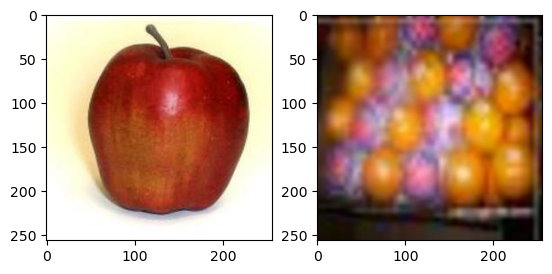

In [14]:
image,label=next(iter(train_data_loader))
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow((image[0]*0.5+0.5).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow((label[0]*0.5+0.5).permute(1,2,0))

plt.show()

In [15]:
# writer_fake=SummaryWriter("logs/GAN_MNIST/fake")

# writer_real=SummaryWriter("logs/GAN_MNIST/real")

# step = 0

# fixed_noise = torch.randn(size=(64,z_dim,1,1))

In [16]:
# z=torch.rand(size=(1,100,1,1))
# z.shape

In [17]:
# img,label=next(iter(data_loader))
# img.shape

In [18]:
# !pip install torchinfo

In [19]:
# from torchinfo import summary

# summary(disc,input_size=[1,3,64,64])

In [20]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)


In [21]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

In [22]:
# summary(gen,input_size=[1,3,265,256])

In [23]:
# gen.eval()
# with torch.inference_mode():
#   print(gen(z.to('cuda')).shape)

In [24]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights
import scipy
import numpy as np

In [25]:
loss_fn=nn.MSELoss()
loss_l1=nn.L1Loss()

optimizer_disc=torch.optim.Adam(params=list(disc_x.parameters())+list(disc_y.parameters()),lr=lr,betas=(0.5,0.999))

optimizer_gen=torch.optim.Adam(params=list(gen_G.parameters())+list(gen_F.parameters()),lr=lr,betas=(0.5,0.999))

In [26]:
from tqdm.auto import tqdm

epochs=100
LOSS_Dx=[]
LOSS_G=[]
LOSS_Dy=[]
LOSS_F=[]
fid_scores=[]

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,y) in enumerate(train_data_loader):
      

    ## traing the discriminators Dx and Dy
    optimizer_disc.zero_grad()
      
    y_fake=gen_G(x.to(device))

    disc_y_real=disc_y(y.to(device))
    
    disc_y_fake=disc_y(y_fake.detach().to(device))

    loss_disc_y_real=loss_fn(disc_y_real,torch.ones_like(disc_y_real))
    loss_disc_y_fake=loss_fn(disc_y_fake,torch.zeros_like(disc_y_fake))
    loss_disc_y=loss_disc_y_real+loss_disc_y_fake
      
    LOSS_Dy.append(loss_disc_y.item())

    x_fake=gen_F(y.to(device))
 
    disc_x_real=disc_x(x.to(device))
      
    disc_x_fake=disc_x(x_fake.detach().to(device))

    loss_disc_x_real=loss_fn(disc_x_real,torch.ones_like(disc_x_real))
    loss_disc_x_fake=loss_fn(disc_x_fake,torch.zeros_like(disc_x_fake))

    loss_disc_x=loss_disc_x_real+loss_disc_x_fake
      
    LOSS_Dx.append(loss_disc_x.item())

    loss_disc=(loss_disc_x+loss_disc_y)/2

      
    loss_disc.backward()

    optimizer_disc.step()

    #training generators G  and F 
    optimizer_gen.zero_grad()

    fool_logits_y=disc_y(y_fake.to(device))
    fool_logits_x=disc_x(x_fake.to(device))

    
    loss_gen_G=loss_fn(fool_logits_y,torch.ones_like(fool_logits_y))
    loss_gen_F=loss_fn(fool_logits_x,torch.ones_like(fool_logits_x))

    f_g_x=gen_F(y_fake.to(device))
    g_f_y=gen_G(x_fake.to(device))


    cyc_loss_g=loss_l1(f_g_x,x.to(device))
    cyc_loss_f=loss_l1(g_f_y,y.to(device))

    id_y=gen_G(y.to(device))
    id_x=gen_F(x.to(device))

    id_y_loss=lambda_id*loss_l1(id_y,y.to(device))
    id_x_loss=lambda_id*loss_l1(id_x,x.to(device))
    

    LOSS_G.append(loss_gen_G.item())
    LOSS_F.append(loss_gen_F.item())

    loss_gen=(loss_gen_G+loss_gen_F+lambda_cyc*cyc_loss_f+lambda_cyc*cyc_loss_g+id_y_loss+id_x_loss)

    loss_gen.backward()
    optimizer_gen.step()

    if batch_idx== 0:
           
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_data_loader)} \
                  Loss Dx: {loss_disc_x:.4f}, loss G: {loss_gen_G:.4f},Loss Dy: {loss_disc_y:.4f}, loss F: {loss_gen_F:.4f}"
            )








  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100] Batch 0/1019                   Loss Dx: 7.6765, loss G: 1.2185,Loss Dy: 3.8309, loss F: 5.5436
Epoch [1/100] Batch 0/1019                   Loss Dx: 0.5058, loss G: 0.5716,Loss Dy: 0.4882, loss F: 0.3405
Epoch [2/100] Batch 0/1019                   Loss Dx: 0.7409, loss G: 0.2762,Loss Dy: 0.5019, loss F: 0.2709
Epoch [3/100] Batch 0/1019                   Loss Dx: 0.4118, loss G: 0.4996,Loss Dy: 0.4032, loss F: 0.5017
Epoch [4/100] Batch 0/1019                   Loss Dx: 0.4567, loss G: 0.6081,Loss Dy: 0.5019, loss F: 0.7052
Epoch [5/100] Batch 0/1019                   Loss Dx: 0.2526, loss G: 0.4368,Loss Dy: 0.3770, loss F: 0.6497
Epoch [6/100] Batch 0/1019                   Loss Dx: 0.3902, loss G: 0.3039,Loss Dy: 0.4122, loss F: 0.4647
Epoch [7/100] Batch 0/1019                   Loss Dx: 0.4460, loss G: 0.4488,Loss Dy: 0.3908, loss F: 0.4518
Epoch [8/100] Batch 0/1019                   Loss Dx: 0.4279, loss G: 0.4353,Loss Dy: 0.2861, loss F: 0.5157
Epoch [9/100] Batch

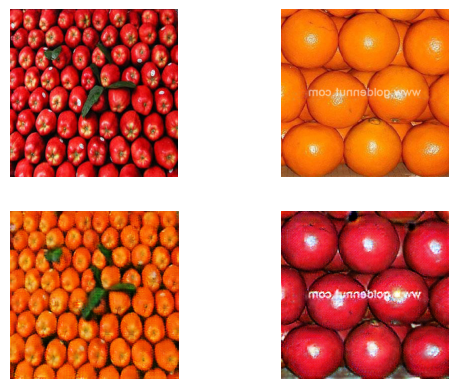

In [122]:
x,y=next(iter(train_data_loader))
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
y_fake=gen_G(x.to(device))
plt.subplot(2,2,3)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
x_fake=gen_F(y.to(device))
plt.subplot(2,2,4)
plt.imshow((x_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()


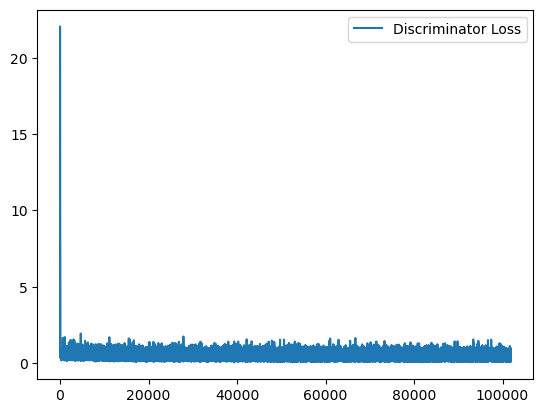

In [123]:
plt.plot(LOSS_Dx,label="Discriminator Loss")
plt.legend()
plt.show()

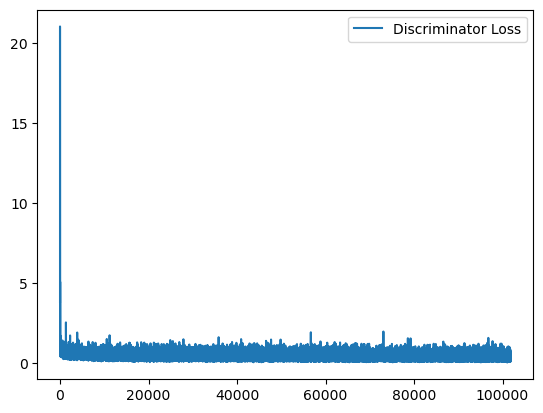

In [29]:
plt.plot(LOSS_Dy,label="Discriminator Loss")
plt.legend()
plt.show()

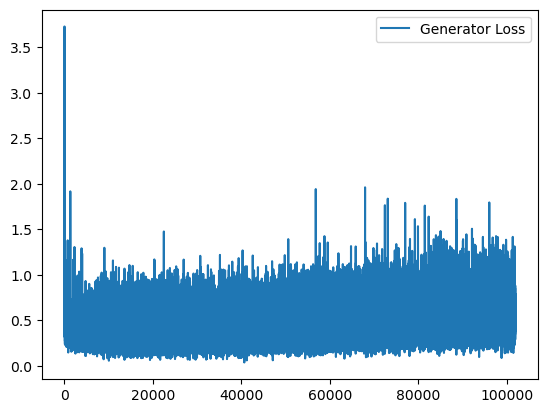

In [30]:
plt.plot(LOSS_G,label="Generator Loss")
plt.legend()
plt.show()

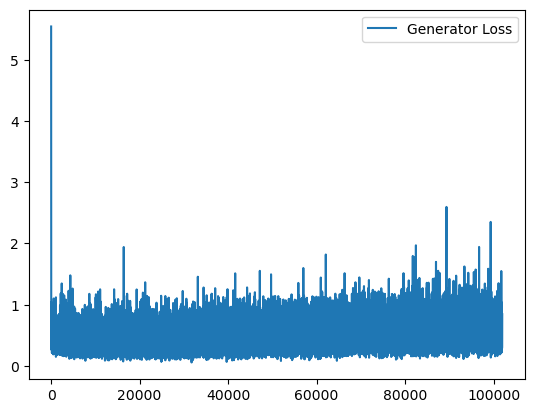

In [31]:
plt.plot(LOSS_F,label="Generator Loss")
plt.legend()
plt.show()

In [124]:
class PartialInceptionNetwork(nn.Module):
  def __init__(self):
    super(PartialInceptionNetwork, self).__init__()
    self.inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)  #initializing pretrsined model
    self.inception_model.Mixed_7c.register_forward_hook(self.output_hook)
    self.output = None

  def output_hook(self, module, input, output):
    self.mixed_7c_output = output

  def forward(self, x):
    assert x.shape[1:] == (3, 299, 299), "Input shape should be (batch_size, 3, 299, 299)"
    self.inception_model(x)
    activations = self.mixed_7c_output
    activations = F.adaptive_avg_pool2d(activations, (1, 1))
    activations = activations.view(x.shape[0],2048)
    return activations

net=PartialInceptionNetwork().to(device)

def fid_score(real_images, gen_images,batch_size):
  real_activations = []
  gen_activations = []
  num_steps=int(math.ceil(float(len(real_images))/float(batch_size)))
  for i in range(num_steps):
    s = i * batch_size
    e=(1+i) * batch_size

    mini_real_batch=real_images[s:e]
    mini_gen_batch=gen_images[s:e]

    batch_real=Variable(mini_real_batch).to(device)
    batch_gen=Variable(mini_gen_batch).to(device)

  features_real=net(batch_real)
  features_gen=net(batch_gen)

  real_activations.append(features_real)
  gen_activations.append(features_gen)

  features_real=torch.cat(real_activations,0)
  features_gen=torch.cat(gen_activations,0)

  xr=features_real.cpu().detach().numpy()
  xg=features_gen.cpu().detach().numpy()

  u1=np.mean(xr,axis=0)
  u2=np.mean(xg,axis=0)
  s1=np.cov(xr,rowvar=False)
  s2=np.cov(xg,rowvar=False)
  print(s1.shape)
  print(s2.shape)

  diff=u1-u2
  diff_squared=diff.dot(diff)

  prod=np.dot(s1,s2)

  sqrt_prod,_=scipy.linalg.sqrtm(prod,disp=False)

  if np.iscomplexobj(sqrt_prod):
      sqrt_prod=sqrt_prod.real

  prod_tr=np.trace(sqrt_prod)

  fid_score=diff_squared+np.trace(s1)+np.trace(s2)-2*prod_tr

  return fid_score

In [127]:
gen_images=y_fake.view(-1,1,256,256)
gen_images=gen_images.repeat(1,3,1,1)
gen_res_images=F.interpolate(gen_images,size=(299,299))
real_images = y.view(-1, 1, 256, 256) # Reshape real_images similar to gen_images
real_images = real_images.repeat(1, 3, 1, 1) # Repeat channels for real_images
real_images = F.interpolate(real_images, size=(299, 299)) # Resize 
net.eval()  # Set the model to evaluation mode
fid = fid_score(real_images, gen_res_images,1)
print(fid)

472.42547961073643


In [125]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import scipy

# Assuming y_fake is your generated images (batch_size, 3, 256, 256)
# and x is your real images (batch_size, 3, 256, 256)

# Resize generated images to (299, 299)
gen_res_images = F.interpolate(y_fake, size=(299, 299)) 

# Resize real images to (299, 299)
real_res_images = F.interpolate(y, size=(299, 299))

# Your PartialInceptionNetwork class definition here (as given above)
# net = PartialInceptionNetwork().to(device)

# FID score calculation function
def fid_score(real_images, gen_images, batch_size):
    real_activations = []
    gen_activations = []
    num_steps = int(math.ceil(float(len(real_images)) / float(batch_size)))
    
    for i in range(num_steps):
        s = i * batch_size
        e = (i + 1) * batch_size

        mini_real_batch = real_images[s:e]
        mini_gen_batch = gen_images[s:e]

        batch_real = Variable(mini_real_batch).to(device)
        batch_gen = Variable(mini_gen_batch).to(device)

        # Get activations from Inception network
        features_real = net(batch_real)
        features_gen = net(batch_gen)

        real_activations.append(features_real)
        gen_activations.append(features_gen)

    # Concatenate all activations
    features_real = torch.cat(real_activations, 0)
    features_gen = torch.cat(gen_activations, 0)

    # Convert activations to numpy for FID computation
    xr = features_real.cpu().detach().numpy()
    xg = features_gen.cpu().detach().numpy()

    # Mean and covariance of activations
    u1 = np.mean(xr, axis=0)
    u2 = np.mean(xg, axis=0)
    s1 = np.cov(xr, rowvar=False)
    s2 = np.cov(xg, rowvar=False)

    # Calculate FID
    diff = u1 - u2
    diff_squared = diff.dot(diff)

    prod = np.dot(s1, s2)
    sqrt_prod, _ = scipy.linalg.sqrtm(prod, disp=False)

    if np.iscomplexobj(sqrt_prod):
        sqrt_prod = sqrt_prod.real

    prod_tr = np.trace(sqrt_prod)

    fid_score = diff_squared + np.trace(s1) + np.trace(s2) - 2 * prod_tr

    return fid_score

# Example usage:
net.eval()  # Set the model to evaluation mode

# Calculate FID score between real and generated images
fid = fid_score(real_res_images, gen_res_images, batch_size=4)  # Adjust batch_size as needed
print(fid)


ValueError: Non-matrix input to matrix function.

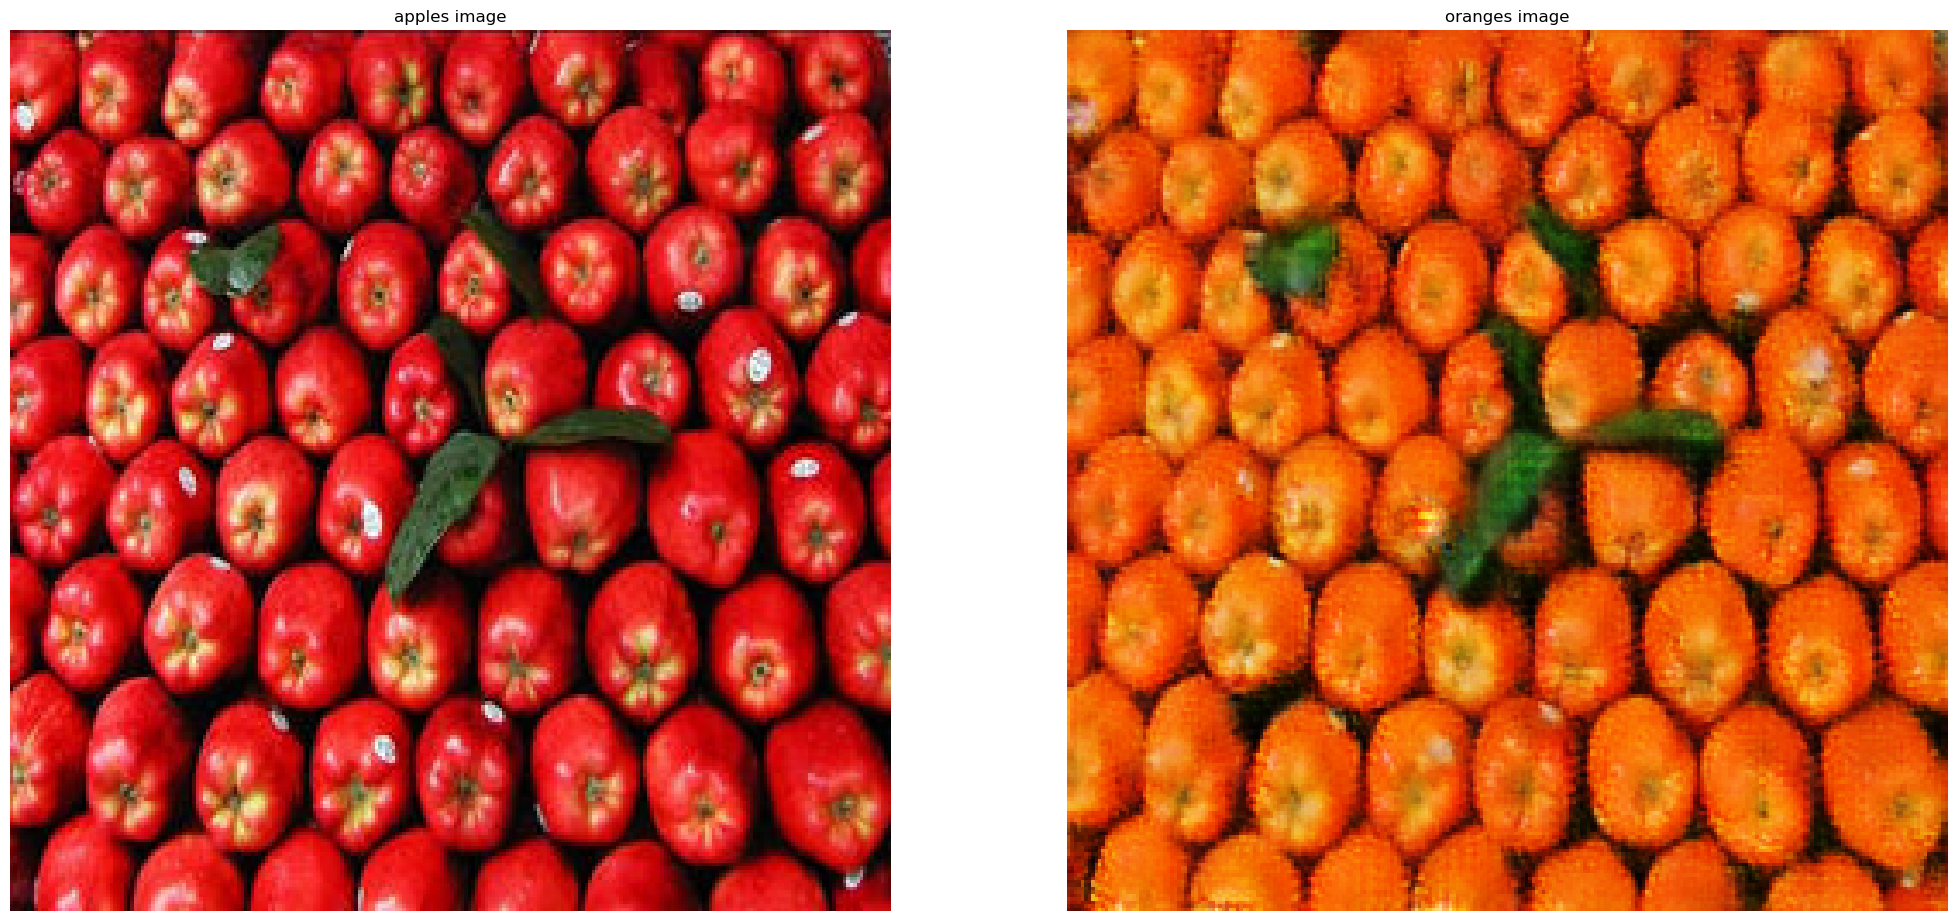

In [130]:
from torchvision.utils import make_grid

# Display images
def show_images(real_images, fake_images):


    

    # Create a grid of images
    real_grid = make_grid(real_images, nrow=8)
    fake_grid = make_grid(fake_images, nrow=8)

    plt.figure(figsize=(25,25))

    # Plot real images
    plt.subplot(1, 2, 1)
    plt.title("apples image")
    plt.imshow((real_grid*0.5+0.5).permute(1, 2, 0).detach())
    plt.axis('off')

    # Plot fake images
    plt.subplot(1, 2, 2)
    plt.title("oranges image")
    plt.imshow((fake_grid*0.5+0.5).cpu().permute(1, 2, 0).detach())
    plt.axis('off')

    plt.show()

# Hyperparameters
batch_size = 32
noise_dim = 100

show_images(x,y_fake)

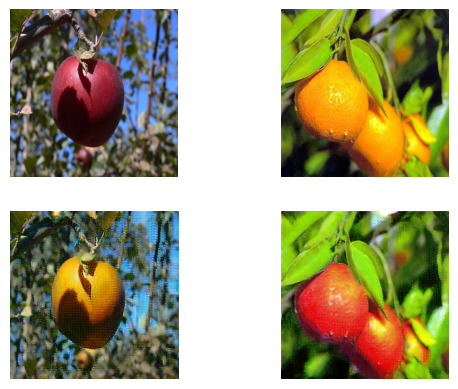

In [152]:
x,y=next(iter(val_data_loader))
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
plt.axis('off')
y_fake=gen_G(x.to(device))
plt.subplot(2,2,3)
plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
x_fake=gen_F(y.to(device))
plt.subplot(2,2,4)
plt.imshow((x_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
plt.axis('off')
plt.show()

In [ ]:
# class process(Dataset):
#     def __init__(self, input_dir):
#         self.input_dir = input_dir
#         self.input_files = os.listdir(self.input_dir)

#     def __len__(self):
#         return len(self.input_files)

#     def __getitem__(self, index):
#         input_img_file = self.input_files[index]


#         input_img_path = os.path.join(self.input_dir, input_img_file)

#         input_image = np.array(Image.open(input_img_path))

#         # Apply augmentations if necessary
#         augmentations = both_x_and_y_transform(image=input_image)
#         input_image = augmentations["image"]
#         if input_image.shape[-1] == 4:
#             input_image = input_image[..., :3]
#         # target_image = augmentations["image0"]

#         # Apply specific transforms if needed
#         input_image = transform_X(image=input_image)["image"]
#         # target_image = transform_Y(image=target_image)["image"]

#         return input_image


In [ ]:
# test_dataset=process(input_dir="data_comics/test_faces")
# # test_data_loader=DataLoader(dataset=test_dataset,batch_size=2,shuffle=True)

In [ ]:
# x,y=next(iter(test_data_loader))
# import matplotlib.pyplot as plt
# plt.subplot(1,3,1)
# plt.imshow((x[0]*0.5+0.5).permute(1,2,0))
# plt.axis('off')
# plt.subplot(1,3,2)
# plt.imshow((y[0]*0.5+0.5).permute(1,2,0))
# plt.axis('off')
# y_fake=gen(x.to(device))
# plt.subplot(1,3,3)
# plt.imshow((y_fake[0]*0.5+0.5).permute(1,2,0).cpu().detach())
# plt.axis('off')
# plt.show()